# Circuit
This is a new version of circuit analysis notebook.
Addresses the following issues:
1. Replacing with transcoders in certain layers will make the results uncomparable. So we turn to the original circuit analysis method in the transcoder paper. That is cache the original model hidden states and only use transcoders to interpret the features inside rather than run with them.
2. Automatic circuit finding. The basic idea is that:

In [1]:
import sys

PROJECT_ROOT = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print('PYTHONPATH added:', sys.path[0])

PYTHONPATH added: /nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl


## Preparation
Load the model and transcoders.

In [2]:
import torch
from vit_prisma.utils.constants import DEVICE
from vit_prisma.utils.tutorial_utils import (
    plot_image,
)

/home/janeding/miniconda3/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import gc

# clear cache
torch.cuda.empty_cache()
# force garbage collection
gc.collect()

torch.cuda.set_device(0)
DEVICE = torch.device('cuda:0')

In [4]:
# transcoder list
from src.analysis.utils import *

tc_list = load_all_tc()

2025-08-29 19:45:57 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/b9ff9647261516e5c7a882f7fd130db702c8ea25/config.json HTTP/1.1" 200 0


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/snapshots/b9ff9647261516e5c7a882f7fd130db702c8ea25/weights.pt...


2025-08-29 19:45:58 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 768}
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:45:58 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/96c293a7299a99fe3d70f1f15498215849f22d96/config.json HTTP/1.1" 200 0
2025-08-29 19:45:59 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 256}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/snapshots/96c293a7299a99fe3d70f1f15498215849f22d96/weights.pt...


2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/cfb7ad837b972edfa27c9719de0e9571893dc434/config.json HTTP/1.1" 200 0
2025-08-29 19:45:59 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/snapshots/cfb7ad837b972edfa27c9719de0e9571893dc434/weights.pt...


2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/3a169de44e8fa1641a9768aa84f3f99a9edd9828/config.json HTTP/1.1" 200 0
2025-08-29 19:45:59 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/snapshots/3a169de44e8fa1641a9768aa84f3f99a9edd9828/weights.pt...


2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:45:59 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/01926c5c792d963b51953bb5922674a484c215a5/config.json HTTP/1.1" 200 0
2025-08-29 19:46:00 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 512}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-512-x64-all_patches_4-mlp-76/snapshots/01926c5c792d963b51953bb5922674a484c215a5/weights.pt...


2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/12ebdd11e4e404bb95bbcab991eee795fb8cf66c/config.json HTTP/1.1" 200 0
2025-08-29 19:46:00 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_5-mlp-91/snapshots/12ebdd11e4e404bb95bbcab991eee795fb8cf66c/weights.pt...


2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/d0d722d64076e3911bff4b56d92a370543f1ca15/config.json HTTP/1.1" 200 0
2025-08-29 19:46:00 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_6-mlp-94/snapshots/d0d722d64076e3911bff4b56d92a370543f1ca15/weights.pt...


2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/010d526da64705bae8b61f1c6b66617a2ecb69f8/config.json HTTP/1.1" 200 0
2025-08-29 19:46:01 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_7-mlp-97/snapshots/010d526da64705bae8b61f1c6b66617a2ecb69f8/weights.pt...


2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/43d0de77b2a27e664be61a74548d30a826db26fe/config.json HTTP/1.1" 200 0
2025-08-29 19:46:01 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_8-mlp-98/snapshots/43d0de77b2a27e664be61a74548d30a826db26fe/weights.pt...


2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/6f57a523ab849e1b5544b94572d539da7c30cbdb/config.json HTTP/1.1" 200 0
2025-08-29 19:46:02 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_9-mlp-98/snapshots/6f57a523ab849e1b5544b94572d539da7c30cbdb/weights.pt...


2025-08-29 19:46:02 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/resolve/main/weights.pt HTTP/1.1" 302 0
2025-08-29 19:46:02 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/resolve/main/config.json HTTP/1.1" 307 0
2025-08-29 19:46:02 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/Prisma-Multimodal/CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/a083216cc058dad1ea74a5b375c6c152b76ca6ad/config.json HTTP/1.1" 200 0
2025-08-29 19:46:02 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}


Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_10-mlp-97/snapshots/a083216cc058dad1ea74a5b375c6c152b76ca6ad/weights.pt...


In [5]:
# load vision model
from vit_prisma.models.model_loader import load_hooked_model
from vit_prisma.utils.enums import ModelType

model_name = 'open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K'

model_v = load_hooked_model(model_name, model_type=ModelType.VISION)
model_v.to(DEVICE)

2025-08-29 19:46:02 INFO:root: Model 'open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K' is supported and passes tests.
2025-08-29 19:46:02 INFO:root: model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
2025-08-29 19:46:02 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_config.json HTTP/1.1" 307 0
2025-08-29 19:46:02 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_config.json HTTP/1.1" 200 0
2025-08-29 19:46:02 INFO:root: HookedViTConfig(n_layers=12, d_model=768, d_head=64, d_mlp=3072, model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K', use_cls_token=True, n_heads=12, activation_name='gelu', d_vocab=-1, eps=1e-05, use_attn_result=False, use_attn_scale=True, use_split_qkv_input=False, use_hook_mlp_in=False, use_attn_in=False, use_lo

HookedViT(
  (embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (hook_embed): HookPoint()
  (pos_embed): PosEmbedding()
  (hook_pos_embed): HookPoint()
  (hook_full_embed): HookPoint()
  (ln_pre): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (hook_ln_pre): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): Ho

In [6]:
# load text model
# load the CLIP text transformer encoder model

import open_clip
import torch
from open_clip.model import text_global_pool
from torch import nn


def name_from_hf(model_name):
    """return model name from huggingface"""
    return model_name.replace('open-clip:', 'hf-hub:')


class OpenCLIPTextOnly(nn.Module):
    def __init__(self, clip):
        super().__init__()
        # only keep the text part of the model
        self.vocab_size = clip.vocab_size
        self.token_embedding = clip.token_embedding
        self.positional_embedding = clip.positional_embedding
        self.transformer = clip.transformer
        self.ln_final = clip.ln_final
        self.text_projection = clip.text_projection
        self.attn_mask = clip.attn_mask
        self.text_pool_type = clip.text_pool_type
        self.text_eos_id = getattr(clip, 'text_eos_id', None)
        # self.register_buffer('attn_mask', self.attn_mask, persistent=False)

    @torch.no_grad()
    def encode_text(self, text, normalize=False):
        cast_dtype = self.transformer.get_cast_dtype()
        x = self.token_embedding(text).to(cast_dtype)  # [B, L, D]
        x = x + self.positional_embedding.to(cast_dtype)
        x = self.transformer(
            x, attn_mask=self.attn_mask
        )  # transformer(width=D)
        x = self.ln_final(x)
        x = text_global_pool(x, text, self.text_pool_type)
        if self.text_projection is not None:
            x = (
                self.text_projection(x)
                if isinstance(self.text_projection, nn.Linear)
                else x @ self.text_projection
            )
        return nn.functional.normalize(x, dim=-1) if normalize else x

    def forward(self, text):
        return self.encode_text(text, normalize=True)


tmp_model, _, _ = open_clip.create_model_and_transforms(
    name_from_hf(tc_list[0].cfg.model_name),
)
tmp_model.to(DEVICE)
tmp_model.eval()

tokenizer = open_clip.get_tokenizer(name_from_hf(tc_list[0].cfg.model_name))

# free up visual tower memory (optional)
if hasattr(tmp_model, 'visual'):
    delattr(tmp_model, 'visual')
    torch.cuda.empty_cache()

model_t = OpenCLIPTextOnly(tmp_model).eval().to(DEVICE)
# text_model.forward(input_ids) or text_model.encode_text(input_ids, normalize=True)

2025-08-29 19:46:03 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_model.safetensors HTTP/1.1" 302 0
2025-08-29 19:46:03 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/resolve/main/open_clip_config.json HTTP/1.1" 307 0
2025-08-29 19:46:03 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_config.json HTTP/1.1" 200 0
2025-08-29 19:46:03 INFO:root: Loaded hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K model config.
2025-08-29 19:46:04 INFO:root: Loading pretrained hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K weights (/home/janeding/.cache/huggingface/hub/models--laion--CLIP-ViT-B-32-DataComp.XL-s13B-b90K/snapshots/f0e2ffa09cbadab3db6a261ec1ec56407ce42912/open_clip_model.safetensors).
2025-08-29 19:46:04 DEBUG:urlli

# Circuit Analysis

## Step 1: Original cache

2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: STREAM b'IHDR' 16 13
2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: STREAM b'sBIT' 41 4
2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: b'sBIT' 41 4 (unknown)
2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: STREAM b'pHYs' 57 9
2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: STREAM b'tEXt' 78 25
2025-08-29 19:46:05 DEBUG:PIL.PngImagePlugin: STREAM b'IDAT' 115 8192
2025-08-29 19:46:05 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 19:46:05 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 19:46:05 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-29 19:46:05 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/janeding/miniconda3/envs/prisma/lib/python3.13/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='Dej

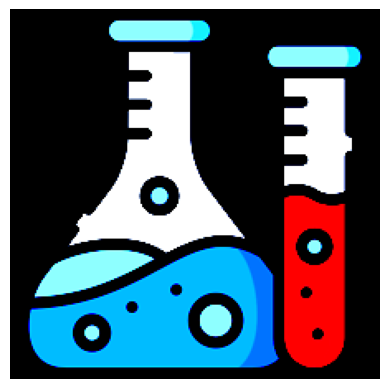

In [7]:
# image

from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms

# img_path = '/nfs/turbo/coe-chaijy/janeding/example_images/smiling-face.png'
img_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl/example_images/flask.png'
gt_label = 'chemistry'
img = Image.open(img_path).convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)

In [8]:
# get the output and cache
model_v.eval()
output, cache = model_v.run_with_cache(img_tensor.to(DEVICE).unsqueeze(0))

In [9]:
# validate the output: model can classify the image correctly
CHUNK_SIZE = 512

import pandas as pd

file_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/MyTC_bert/data/concrete_visual_vocabulary.csv'
labels = pd.read_csv(file_path)

labels = labels.dropna(subset=['word'])
labels['word'] = labels['word'].astype(str).str.lower().str.strip()
labels = labels[labels['word'].ne('')]
labels = labels[labels['word'].ne('nan')]

# turn into dict
label_dict = {
    row['word']: {
        'concreteness': row['concreteness'],
        'imageability': row['imageability'],
    }
    for _, row in labels.iterrows()
}


labels = list(label_dict.keys())
prompts = [f'a photo of a {l}' for l in labels]
text_tokens = open_clip.tokenize(prompts)  # [N, 77] on CPU

with torch.no_grad():
    image_input = img_tensor.unsqueeze(0).to(DEVICE)
    image_features = model_v(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_feats_out = []
    for i in range(0, len(text_tokens), CHUNK_SIZE):
        chunk = text_tokens[i : i + CHUNK_SIZE].to(DEVICE, non_blocking=True)
        feats = model_t.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(DEVICE)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_idx = text_probs.squeeze().topk(10)

for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
    print(f'{i + 1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}')


1. label: chemistry            | prob: 0.0634
2. label: insolubility         | prob: 0.0393
3. label: solubility           | prob: 0.0309
4. label: test tube            | prob: 0.0301
5. label: science              | prob: 0.0263
6. label: toxicology           | prob: 0.0228
7. label: osmosis              | prob: 0.0213
8. label: scientifically       | prob: 0.0201
9. label: reformulation        | prob: 0.0128
10. label: liquidate            | prob: 0.0121


## Step 2: prepare the hooks

In [10]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'hook_full_embed', 'ln_pre.hook_scale', 'ln_pre.hook_normalized', 'hook_ln_pre', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.h

In [11]:
transcoder = tc_list[0]
transcoder.cfg

VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K', vit_model_cfg=None, model_path=None, hook_point_layer=0, layer_subtype='ln2.hook_normalized', hook_point_head_index=None, context_size=50, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=64, from_pretrained_path=None, is_transcoder=True, transcoder_with_skip_connection=True, out_hook_point_layer=0, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='topk', activation_fn_kwargs={'k': 768}, cls_token_only=False, max_grad_norm=1.0, initialization_method='independent', normalize_activations='layer_norm', n_batches_in_buffer=20, sto

In [12]:
def get_act_name(act_type, layer):
    if act_type == 'mlp_input':
        return f'blocks.{layer}.ln2.hook_normalized'
    elif act_type == 'mlp_output':
        return f'blocks.{layer}.mlp.hook_mlp_out'
    else:
        raise ValueError(f'Invalid act_type: {act_type}')


In [13]:
def replace_hook(new_resid, hook):
    """Replace the selected features in the original model resid."""
    return new_resid

In [ ]:
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    import gc

    gc.collect()

## Step 1: Concepts

In [ ]:
# label set

# only allow related concept features


def make_layer_feature_mask(allow_feature_ids: list[int], d_sae: int):
    """Set the feature ids for the greedy path search to be true."""
    mask = torch.zeros(d_sae)
    mask[allow_feature_ids] = 1
    return mask


In [ ]:
import random
from typing import Any, Optional

import numpy as np
import torch
import torch.nn.functional as F


class AblationExperimentRunner:
    """
    Encapsulates the logic for running a suite of ablation experiments
    on a HookedTranscoderViT model, ensuring comparability between different
    ablation methods by using a feature injection technique. Will run 4 types of
    forward passes:
    - Original CLIP baseline
    - Transcoder baseline
    - Zero Ablation
    - Gaussian Noise Ablation (with n_gn_samples samples)

    The feature activations from the transcoder baseline are used to inject
    zero and Gaussian noise into the model for apple-to-apple comparison.
    """

    def __init__(
        self,
        model: 'HookedTranscoderViT',
        transcoders: list[SparseAutoencoder],
        img_tensor: torch.Tensor,
        labels: list[str],
        text_features: torch.Tensor,
        device='cuda',
        activated_layers: Optional[list[int]] = None,
    ):
        self.model = model
        self.transcoders = {tc.cfg.hook_point_layer: tc for tc in transcoders}
        self.img_tensor = img_tensor.to(device)
        self.labels = labels
        self.text_features = text_features.to(device)
        self.device = device
        self.gn_generator = torch.Generator(device=device)
        self.results: dict[str, Any] = {}
        self.activated_layers = activated_layers

    @staticmethod
    def set_seeds(seed: int):
        """Sets random seeds for reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _format_text_probs(self, probs, idxs) -> dict[str, float]:
        """Formats text probabilities into a dictionary."""
        return {
            self.labels[idx.item()]: prob.item()
            for prob, idx in zip(probs, idxs)
        }

    # def _run_forward_pass(
    #     self,
    #     transcoders_to_use: list[SparseAutoencoder],
    #     fwd_hooks,
    #     batch_size=1,
    #     capture_config: Optional[dict[str, str]] = None,
    # ) -> dict[str, Any]:
    #     """Helper to run the model and get logits and text probabilities."""
    #     all_fwd_hooks = list(fwd_hooks)
    #     captured_data = {}

    #     if capture_config is not None:
    #         for name, hook_point in capture_config.items():
    #             captured_data[name] = None

    #             def make_capture_hook(capture_name: str):
    #                 def _capture_hook(activations, hook):
    #                     nonlocal captured_data
    #                     captured_data[capture_name] = (
    #                         activations.clone().detach()
    #                     )

    #                 return _capture_hook

    #             all_fwd_hooks.append((hook_point, make_capture_hook(name)))

    #     with torch.no_grad():
    #         img_input = self.img_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1)
    #         img_input = img_input.to(self.device)

    #         vis_out = self.model.run_with_hooks_with_transcoders(
    #             img_input,
    #             transcoders=transcoders_to_use,
    #             fwd_hooks=all_fwd_hooks,
    #             bwd_hooks=[],
    #             reset_hooks_end=True,
    #         )

    def run_forward_pass(
        self,
        transcoders: list[SparseAutoencoder],
        fwd_hooks,
    ):
        """Wrapper around 'run_with_cache_with_transcoders' in HookedTranscoderViT, for processing the results."""
        vis_out, cache = self.model.run_with_cache_with_transcoders(
            transcoders=transcoders,
            fwd_hooks=fwd_hooks,
        )
        results = self.get_probs_logits(vis_out)
        results['cache'] = cache
        return results

    def get_probs_logits(self, vis_out):
        """Get the text probabilities and logits for the given vision output."""
        image_features = vis_out.to(self.device)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_features @ self.text_features.T
        text_probs = logits.softmax(dim=-1)

        # clear the gpu memory
        del image_features
        clear_gpu_memory()

        results = {
            'text_probs': text_probs,
            'logits': logits,
        }
        return results

    def run_original_clip_baseline(self, seed: int, k: int = 20):
        """Runs the baseline CLIP model without any transcoders."""
        print(f'--- [Seed {seed}] Running Original CLIP Baseline ---')
        self.set_seeds(seed)
        self.model.eval()
        # This resets all transcoders, restoring the original MLP layers
        # self.model.reset_transcoders()
        results = self.run_forward_pass(
            transcoders=[],
            fwd_hooks=[],  # no need to add, for clarity
        )
        top_probs, top_idx = results['text_probs'].squeeze(dim=0).topk(k)
        self.results[f'original_clip_seed{seed}'] = {
            'text_probs': self._format_text_probs(top_probs, top_idx),
            'logits': results['logits'].squeeze(dim=0),
            'cache': results['cache'],
        }
        print('Original CLIP Baseline Done.')
        clear_gpu_memory()

    def set_activated_layers(self, layers: Optional[list[int]]):
        if layers is None:
            self.activated_layers = None
            return
        layers = sorted(set(layers))
        for l in layers:
            if l not in self.transcoders:
                raise ValueError(f'Layer {l} not found in the transcoders.')
        self.activated_layers = layers

    def _ctx(self, layers: Optional[list[int]]):
        return 'all' if layers is None else '_'.join(map(str, layers))

    def _transcoder_layers(self, activated_layers: Optional[list[int]]):
        if activated_layers is None:
            activated_layers = self.activated_layers
        if activated_layers is None:
            return [
                self.transcoders[l] for l in sorted(self.transcoders.keys())
            ]
        for l in activated_layers:
            if l not in self.transcoders.keys():
                raise ValueError(f'Layer {l} not found in the transcoders.')
        return [self.transcoders[l] for l in activated_layers]

    def _set_activated_layers(
        self,
        layer_idx: Union[int, list[int]],
        activated_layers: Optional[list[int]],
    ):
        if isinstance(layer_idx, int):
            layers_to_add = [layer_idx]
        else:
            layers_to_add = list(layer_idx)
        if activated_layers is None:
            activated_layers = self.activated_layers
        if activated_layers is None:
            activated_layers = layers_to_add
        else:
            activated_layers = sorted(set([*activated_layers, *layers_to_add]))
        return activated_layers

    def _get_activated_layers(self, layer_idx: Union[int, list[int]]):
        """Get the activated layers for replacing the transcoder layers."""
        if self.activated_layers is None:
            return layer_idx
        return self.activated_layers

    def agg_gn_results(self, key: str):
        """Aggregate the Gaussian noise results for a given key."""
        if key not in self.results:
            raise ValueError(f'Key {key} not found in results.')
        gn_results = self.results[key]

        if (
            'all_features' in key
        ):  # Handles single run with all features ablated
            logits = [sample_res['all']['logits'] for sample_res in gn_results]
            mean_logits = torch.stack(logits).mean(dim=0)
            mean_text_probs = mean_logits.softmax(dim=-1)
            top_probs, top_idx = mean_text_probs.topk(20)
            return self._format_text_probs(top_probs, top_idx), mean_logits

        elif (
            'each_feature' in key
        ):  # Handles batch run with one feature ablated per item
            logits_per_feature = {}
            for sample_res in gn_results:
                for feat_id, fea_data in sample_res.items():
                    logits_per_feature.setdefault(feat_id, []).append(
                        fea_data['logits']
                    )

            aggregated_results = {}
            for feat_id, logits_list in logits_per_feature.items():
                mean_logits = torch.stack(logits_list).mean(dim=0)
                mean_text_probs = mean_logits.softmax(dim=-1)
                top_probs, top_idx = mean_text_probs.topk(20)
                aggregated_results[feat_id] = {
                    'text_probs': self._format_text_probs(top_probs, top_idx),
                    'mean_logits': mean_logits,
                }
            return aggregated_results

        else:
            raise ValueError(
                f'Invalid key format: {key}. Key must contain "all_features" or "each_feature".'
            )

    def get_inverse_ids(
        self, features_to_preserve: list[int], total_features: int
    ) -> list[int]:
        total_features_set = set(range(total_features))
        features_to_preserve_set = set(features_to_preserve)
        return sorted(list(total_features_set - features_to_preserve_set))

    def _run_ablation_suite_batch(
        self,
        ablation_feature_ids,
        runtime_batch_size,
        transcoders,
        zero_hook_builder,
        gn_hook_builder,
        seed,
        n_gn_samples,
        layer_idx,
        ctx,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        all_zero_ablation_results = {}
        all_gn_ablation_results = [{} for _ in range(n_gn_samples)]

        runtime_batch_size = min(runtime_batch_size, len(ablation_feature_ids))
        for i in range(0, len(ablation_feature_ids), runtime_batch_size):
            chunk_feature_ids = ablation_feature_ids[i : i + runtime_batch_size]
            chunk_size = len(chunk_feature_ids)

            chunk_num = i // runtime_batch_size + 1
            total_chunks = (
                len(ablation_feature_ids) - 1
            ) // runtime_batch_size + 1
            print(
                f'Running zero ablation for chunk {chunk_num} of '
                f'{total_chunks}...'
            )

            zero_hooks = zero_hook_builder(chunk_feature_ids)
            zero_results = self._run_forward_pass(
                transcoders_to_use=transcoders,
                fwd_hooks=zero_hooks,
                batch_size=chunk_size,
                capture_config=capture_config,
            )
            # process the results
            for j, feature_id in enumerate(chunk_feature_ids):
                top_probs, top_idx = zero_results['text_probs'][j].topk(20)
                all_zero_ablation_results[feature_id] = {
                    'text_probs': self._format_text_probs(top_probs, top_idx),
                    'logits': zero_results['logits'][j],
                }
                if capture_config is not None:
                    assert 'captured_data' in zero_results, (
                        'captured_data not found in results'
                    )
                    all_zero_ablation_results[feature_id]['captured_data'] = {
                        k: v[j]
                        for k, v in zero_results['captured_data'].items()
                    }

            print('Zero Ablation Done.')

            # 2b. Gaussian Noise Ablation
            print(
                f'--- [Seed {seed}] Running Gaussian Noise Ablation for '
                f'L{layer_idx} ({n_gn_samples} samples) ---'
            )
            for sample_idx in range(n_gn_samples):
                gn_seed = seed * 100 + sample_idx

                # def inject_hook_gn_ablation(activations, hook):
                #     modified_activations = captured_activations.repeat(
                #         activations.shape[0], 1, 1
                #     )
                #     return gaussian_ablate_feature_hook(
                #         modified_activations,
                #         hook,
                #         feature_ids=chunk_feature_ids,
                #         sigma=sigma,
                #         match_scale=True,
                #         seed=gn_seed,
                #         batch_mode=True,
                #     )
                gn_hooks = gn_hook_builder(chunk_feature_ids, gn_seed)
                gn_results = self._run_forward_pass(
                    transcoders_to_use=transcoders,
                    fwd_hooks=gn_hooks,
                    batch_size=chunk_size,
                    capture_config=capture_config,
                )
                # process the results
                for j, feature_id in enumerate(chunk_feature_ids):
                    top_probs, top_idx = gn_results['text_probs'][j].topk(20)
                    all_gn_ablation_results[sample_idx][feature_id] = {
                        'text_probs': self._format_text_probs(
                            top_probs, top_idx
                        ),
                        'logits': gn_results['logits'][j],
                    }
                    if capture_config is not None:
                        assert 'captured_data' in gn_results, (
                            'captured_data not found in results'
                        )
                        all_gn_ablation_results[sample_idx][feature_id][
                            'captured_data'
                        ] = {
                            k: v[j]
                            for k, v in gn_results['captured_data'].items()
                        }

            print('GN Ablation Done.')

        self.results[
            f'{output_prefix}zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ] = all_zero_ablation_results
        self.results[
            f'{output_prefix}gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ] = all_gn_ablation_results

    def _get_zero_abl_hook(
        self, captured_activations, hook_point, feature_ids, batch_mode=True
    ):
        def inject_hook_zero_ablation(activations, hook):
            return zero_ablate_feature_hook(
                captured_activations.clone()
                .detach()
                .repeat(activations.shape[0], 1, 1),
                hook,
                feature_ids=feature_ids,
                batch_mode=batch_mode,
            )

        return (hook_point, inject_hook_zero_ablation)

    def _get_gn_abl_hook(
        self,
        captured_activations,
        hook_point,
        feature_ids,
        sigma,
        seed,
        batch_mode=True,
    ):
        def inject_hook_gn_ablation(activations, hook):
            return gaussian_ablate_feature_hook(
                captured_activations.clone()
                .detach()
                .repeat(activations.shape[0], 1, 1),
                hook,
                feature_ids=feature_ids,
                sigma=sigma,
                match_scale=True,
                seed=seed,
                batch_mode=batch_mode,
            )

        return (hook_point, inject_hook_gn_ablation)

    def _build_zero_hooks_builder(
        self, captured_activations, hook_point, batch_mode: bool
    ):
        def builder(feature_ids):
            return [
                self._get_zero_abl_hook(
                    captured_activations,
                    hook_point,
                    feature_ids,
                    batch_mode=batch_mode,
                )
            ]

        return builder

    def _build_gn_hooks_builder(
        self, captured_activations, hook_point, sigma: float, batch_mode: bool
    ):
        def builder(feature_ids, gn_seed: int):
            return [
                self._get_gn_abl_hook(
                    captured_activations,
                    hook_point,
                    feature_ids,
                    sigma,
                    gn_seed,
                    batch_mode=batch_mode,
                )
            ]

        return builder

    def _run_ablation_suite_single(
        self,
        # ablation_feature_ids,
        # captured_activations,
        transcoders,
        zero_hooks,
        gn_hook_builder,
        # hook_point,
        seed,
        n_gn_samples,
        # sigma,
        layer_idx,
        ctx,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        all_zero_ablation_results = {'all': {}}
        all_gn_ablation_results = [{} for _ in range(n_gn_samples)]

        zero_results = self._run_forward_pass(
            transcoders_to_use=transcoders,
            fwd_hooks=zero_hooks,
            capture_config=capture_config,
        )
        # process the results
        top_probs, top_idx = zero_results['text_probs'].squeeze(dim=0).topk(20)
        all_zero_ablation_results['all'] = {
            'text_probs': self._format_text_probs(top_probs, top_idx),
            'logits': zero_results['logits'].squeeze(dim=0),
        }
        if capture_config is not None:
            assert 'captured_data' in zero_results, (
                'captured_data not found in results'
            )
            all_zero_ablation_results['all']['captured_data'] = {
                k: v.squeeze(dim=0)
                for k, v in zero_results['captured_data'].items()
            }
        print('Zero Ablation Done.')

        print(
            f'--- [Seed {seed}] Running Gaussian Noise Ablation for '
            f'L{layer_idx} ({n_gn_samples} samples) ---'
        )
        for sample_idx in range(n_gn_samples):
            gn_seed = seed * 100 + sample_idx
            gn_hooks = (
                gn_hook_builder(gn_seed)
                if callable(gn_hook_builder)
                else gn_hook_builder[sample_idx]
            )
            gn_results = self._run_forward_pass(
                transcoders_to_use=transcoders,
                fwd_hooks=gn_hooks,
                capture_config=capture_config,
            )
            top_probs, top_idx = (
                gn_results['text_probs'].squeeze(dim=0).topk(20)
            )
            all_gn_ablation_results[sample_idx]['all'] = {
                'text_probs': self._format_text_probs(top_probs, top_idx),
                'logits': gn_results['logits'].squeeze(dim=0),
            }
            if capture_config is not None:
                assert 'captured_data' in gn_results, (
                    'captured_data not found in results'
                )
                all_gn_ablation_results[sample_idx]['all']['captured_data'] = {
                    k: v.squeeze(dim=0)
                    for k, v in gn_results['captured_data'].items()
                }
        print('GN Ablation Done.')
        self.results[
            f'{output_prefix}zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_all_features'
        ] = all_zero_ablation_results
        self.results[
            f'{output_prefix}gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_all_features'
        ] = all_gn_ablation_results

    def run_ablation_suite(
        self,
        layer_idx: int,
        seed: int = 42,
        n_gn_samples: int = 10,
        sigma: float = 1.0,
        batch_mode: bool = True,
        activated_layers: Optional[list[int]] = None,
        runtime_batch_size: int = 512,
        ablation_feature_ids: Optional[list[int]] = None,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        """
        Runs the full suite of experiments for a single layer and seed.
        1. Captures baseline activations with the transcoder if not already run.
        2. Runs zero and Gaussian noise ablations by injecting modified versions
           of the captured activations.

        Args:
            layer_idx: The layer index to run the experiments on.
            n_gn_samples: The number of Gaussian noise samples to run.
            sigma: The standard deviation of the Gaussian noise.
            batch_mode: Whether to run the ablation in batch mode.
            activated_layers: The layer indices to replace the transcoder layers
            for.
            runtime_batch_size: The batch size to use for the runtime.
            ablation_feature_ids: The feature ids to ablate. If None, will use
                the top activation feature ids for each layer.
        """
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        self.set_seeds(seed)
        self.model.eval()

        # --- Step 1: Run the transcoder baseline if not already run ---
        layer_ctx = str(layer_idx)
        if f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}' not in self.results:
            captured_activations, top_act_ids = self.run_transcoder_baseline(
                layer_idx, seed, activated_layers
            )
        else:
            captured_activations = self.results[
                f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'
            ]['captured_activations']
            top_act_ids = self.results[
                f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'
            ]['top_act_ids']

        if ablation_feature_ids is None:
            ablation_feature_ids = top_act_ids[layer_idx]
            assert ablation_feature_ids is not None, (
                'No top activation feature ids found.'
            )

        print(f'Top activation features number: {len(top_act_ids[layer_idx])}')

        # --- Step 2: Run ablation experiments using injection ---
        hook_point = f'blocks.{layer_idx}.mlp.hook_hidden_post'
        transcoders = self._transcoder_layers(activated_layers)

        print(f'--- [Seed {seed}] Running Zero Ablation for L{layer_idx} ---')
        zero_hooks_builder = self._build_zero_hooks_builder(
            captured_activations[layer_idx], hook_point, batch_mode
        )
        gn_hooks_builder = self._build_gn_hooks_builder(
            captured_activations[layer_idx], hook_point, sigma, batch_mode
        )

        if batch_mode:
            self._run_ablation_suite_batch(
                ablation_feature_ids,
                runtime_batch_size,
                transcoders,
                zero_hooks_builder,
                gn_hooks_builder,
                seed,
                n_gn_samples,
                layer_idx,
                ctx,
            )

        # ablate all the features in one forward pass
        else:
            print(
                f'--- [Seed {seed}] Running Zero Ablation for L{layer_idx} ---'
            )

            zero_hooks = zero_hooks_builder(ablation_feature_ids)
            gn_hooks = [
                gn_hooks_builder(ablation_feature_ids, seed * 100 + sample_idx)
                for sample_idx in range(n_gn_samples)
            ]

            self._run_ablation_suite_single(
                transcoders,
                zero_hooks,
                gn_hooks,
                seed,
                n_gn_samples,
                layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        print('Ablation Suite Done.')
        clear_gpu_memory()

    def get_fea_act_summary(
        self, base_activations, post_activations, monitored_ids
    ):
        """Sum over batch and patch dimensions"""
        base_sum = base_activations.sum(
            dim=tuple(range(base_activations.dim() - 1))
        )
        post_sum = post_activations.sum(
            dim=tuple(range(post_activations.dim() - 1))
        )
        summary = {}
        # if the monitored_ids is not provided, use all the features
        if monitored_ids is None:
            monitored_ids = range(base_sum.shape[0])

        # for all features
        base_mean = base_sum.mean(dim=0)
        post_mean = post_sum.mean(dim=0)
        direction = (
            'up'
            if post_mean > base_mean
            else 'down'
            if post_mean < base_mean
            else 'same'
        )
        relative_act = (base_mean - post_mean) / (base_mean + 1e-10)
        summary['all_features'] = {
            'baseline_mean_activation': base_mean.item(),
            'ablated_mean_activation': post_mean.item(),
            'relative_act': relative_act.item(),
            'direction': direction,
        }

        # for other features that are not monitored
        other_ids = set(range(base_sum.shape[0])) - set(monitored_ids)
        # check if there are other features
        if len(other_ids) > 0:
            other_ids = sorted(list(other_ids))
            other_base_sum = base_sum[other_ids]
            other_post_sum = post_sum[other_ids]
            other_base_mean = other_base_sum.mean(dim=0)
            other_post_mean = other_post_sum.mean(dim=0)
            other_direction = (
                'up'
                if other_post_mean > other_base_mean
                else 'down'
                if other_post_mean < other_base_mean
                else 'same'
            )
            other_relative_act = (other_base_mean - other_post_mean) / (
                other_base_mean + 1e-10
            )
            summary['other_features'] = {
                'baseline_mean_activation': other_base_mean.item(),
                'ablated_mean_activation': other_post_mean.item(),
                'relative_act': other_relative_act.item(),
                'direction': other_direction,
            }

        # for all monitored features
        mnt_base_mean = base_sum[monitored_ids].mean(dim=0)
        mnt_post_mean = post_sum[monitored_ids].mean(dim=0)
        mnt_direction = (
            'up'
            if mnt_post_mean > mnt_base_mean
            else 'down'
            if mnt_post_mean < mnt_base_mean
            else 'same'
        )
        mnt_relative_act = (mnt_base_mean - mnt_post_mean) / (
            mnt_base_mean + 1e-10
        )
        summary['mnt_features'] = {
            'baseline_mean_activation': mnt_base_mean.item(),
            'ablated_mean_activation': mnt_post_mean.item(),
            'relative_act': mnt_relative_act.item(),
            'direction': mnt_direction,
        }

        # for each monitored feature
        summary['per_mnt_feature'] = {}
        for mon_f_id in monitored_ids:
            base_val = base_sum[mon_f_id].item()
            post_val = post_sum[mon_f_id].item()
            direction = (
                'up'
                if post_val > base_val
                else 'down'
                if post_val < base_val
                else 'same'
            )
            relative_act = (base_val - post_val) / (base_val + 1e-10)
            summary['per_mnt_feature'][mon_f_id] = {
                'baseline_sum_activation': base_val,
                'ablated_sum_activation': post_val,
                'relative_act': relative_act,
                'direction': direction,
            }
        return summary

    def monitor_abl_activations(
        self,
        abl_layer_idx: int,
        monitor_layer_idx: int,
        seed: int = 42,
        n_gn_samples: int = 10,
        sigma: float = 1.0,
        batch_mode: bool = True,
        activated_layers: Optional[list[int]] = None,
        runtime_batch_size: int = 512,
        ablation_feature_ids: Optional[list[int]] = None,
        monitor_feature_ids: Optional[list[int]] = None,
    ):
        """
        Runs the full suite of experiments for a single layer and seed.
        1. Captures baseline activations with the transcoder if not already run.
        2. Runs zero and Gaussian noise ablations by injecting modified versions
           of the captured activations.

        Args:
            layer_idx: The layer index to run the experiments on.
            n_gn_samples: The number of Gaussian noise samples to run.
            sigma: The standard deviation of the Gaussian noise.
            batch_mode: Whether to run the ablation in batch mode.
            activated_layers: The layer indices to replace the transcoder layers
            for.
            runtime_batch_size: The batch size to use for the runtime.
            ablation_feature_ids: The feature ids to ablate. If None, will use
                the top activation feature ids for each layer.
        """
        # set the activated layers
        activated_layers = self._set_activated_layers(
            abl_layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        self.set_seeds(seed)
        self.model.eval()

        # --- Step 1: Run the transcoder baseline if not already run ---
        layers_to_cap = [abl_layer_idx, monitor_layer_idx]
        layer_ctx = '_'.join(map(str, sorted(layers_to_cap)))
        baseline_key = f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'

        if baseline_key not in self.results:
            self.run_transcoder_baseline(layers_to_cap, seed, activated_layers)

        baseline_results = self.results[baseline_key]
        captured_activations = baseline_results['captured_activations'][
            abl_layer_idx
        ]
        top_act_ids = baseline_results['top_act_ids']
        baseline_mnt_activations = baseline_results['captured_activations'][
            monitor_layer_idx
        ]

        # --- Step 2: Run ablation experiments using injection ---
        abl_hook_point = f'blocks.{abl_layer_idx}.mlp.hook_hidden_post'
        monitor_hook_point = f'blocks.{monitor_layer_idx}.mlp.hook_hidden_post'
        transcoders = self._transcoder_layers(activated_layers)

        zero_hooks_builder = self._build_zero_hooks_builder(
            captured_activations, abl_hook_point, batch_mode
        )
        gn_hooks_builder = self._build_gn_hooks_builder(
            captured_activations, abl_hook_point, sigma, batch_mode
        )
        capture_config = {
            'ablation': abl_hook_point,
            'monitor': monitor_hook_point,
        }
        output_prefix = f'mnt_L{monitor_layer_idx}_abl{abl_layer_idx}'

        print(
            f'--- [Seed {seed}] Running Zero Ablation for L{abl_layer_idx} ---'
        )

        if batch_mode:
            self._run_ablation_suite_batch(
                ablation_feature_ids,
                runtime_batch_size,
                transcoders,
                zero_hooks_builder,
                gn_hooks_builder,
                seed,
                n_gn_samples,
                abl_layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        # ablate all the features in one forward pass
        else:
            print(
                f'--- [Seed {seed}] Running Zero Ablation for L{abl_layer_idx} ---'
            )
            zero_hooks = zero_hooks_builder(ablation_feature_ids)

            def _provider(sample_idx: int):
                gn_seed = seed * 100 + sample_idx
                return gn_hooks_builder(ablation_feature_ids, gn_seed)

            gn_hooks = _provider
            self._run_ablation_suite_single(
                transcoders,
                zero_hooks,
                gn_hooks,
                seed,
                n_gn_samples,
                abl_layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        print('Ablation Suite Done.')

        # --- Step 3: Analyze the changes in the abl / mnt features' activations ---
        def _analyze_fea_act(baseline_act, feature_ids, type='mnt'):
            analysis_results = {}
            analysis_key = f'analysis_{type}_{output_prefix}TC{ctx}_seed{seed}'

            base_act_full = baseline_act
            base_act_sliced = base_act_full

            if feature_ids is not None:
                fea_tensor = torch.tensor(
                    feature_ids, device=base_act_full.device
                )
                base_act_sliced = base_act_sliced.index_select(-1, fea_tensor)

            # zero ablation analysis
            zero_results_key = f'{output_prefix}zero_abl_L{abl_layer_idx}_TC{ctx}_seed{seed}_each_feature'
            if zero_results_key in self.results:
                for abl_fid, data in self.results[zero_results_key].items():
                    if type == 'mnt':
                        abl_act_full = data['captured_data']['monitor']
                    elif type == 'abl':
                        abl_act_full = data['captured_data']['ablation']
                    else:
                        raise ValueError(f'Invalid type: {type}')
                    abl_act_sliced = abl_act_full
                    if feature_ids is not None:
                        abl_act_sliced = abl_act_full.index_select(
                            -1, fea_tensor
                        )

                    delta = abl_act_sliced - base_act_sliced
                    fea_summary = self.get_fea_act_summary(
                        base_act_full, abl_act_full, feature_ids
                    )
                    # cos sim
                    cos_sim = F.cosine_similarity(
                        base_act_sliced.flatten(),
                        abl_act_sliced.flatten(),
                        dim=0,
                    ).item()
                    analysis_results.setdefault(abl_fid, {}).update(
                        {
                            'baseline_activation': base_act_sliced.cpu(),
                            'zero_ablated_activation': abl_act_sliced.cpu(),
                            'zero_delta': delta.cpu(),
                            'zero_delta_norm': torch.norm(delta, p=2).item(),
                            'zero_cos_sim': cos_sim,
                            'zero_fea_summary': fea_summary,
                        }
                    )

            # gn ablation analysis
            gn_results_key = f'{output_prefix}gn_abl_L{abl_layer_idx}_TC{ctx}_seed{seed}_each_feature'
            if gn_results_key in self.results and n_gn_samples > 0:
                gn_results_per_sample = self.results[gn_results_key]
                agg_gn_results = {}
                # aggregate the gn results per feature
                for sample_res in gn_results_per_sample:
                    for abl_fid, data in sample_res.items():
                        if type == 'mnt':
                            abl_act_full = data['captured_data']['monitor']
                        elif type == 'abl':
                            abl_act_full = data['captured_data']['ablation']
                        else:
                            raise ValueError(f'Invalid type: {type}')
                        agg_gn_results.setdefault(abl_fid, []).append(
                            abl_act_full
                        )

                for abl_fid, act_list in agg_gn_results.items():
                    abl_act_full = torch.stack(act_list).mean(dim=0)
                    abl_act_sliced = abl_act_full
                    if feature_ids is not None:
                        abl_act_sliced = abl_act_full.index_select(
                            -1, fea_tensor
                        )

                    delta = abl_act_sliced - base_act_sliced
                    fea_summary = self.get_fea_act_summary(
                        base_act_full, abl_act_full, feature_ids
                    )
                    cos_sim = F.cosine_similarity(
                        base_act_sliced.flatten(),
                        abl_act_sliced.flatten(),
                        dim=0,
                    ).item()
                    analysis_results.setdefault(abl_fid, {}).update(
                        {
                            'gn_mean_ablated_activation': abl_act_sliced.cpu(),
                            'gn_delta': delta.cpu(),
                            'gn_delta_norm': torch.norm(delta, p=2).item(),
                            'gn_cos_sim': cos_sim,
                            'gn_fea_summary': fea_summary,
                        }
                    )
                self.results[analysis_key] = analysis_results

        print(
            f"--- [Seed {seed}] Analyzing the changes in the mnt features' activations ---"
        )
        _analyze_fea_act(
            baseline_mnt_activations, monitor_feature_ids, type='mnt'
        )
        print(
            f"--- [Seed {seed}] Analyzing the changes in the abl features' activations ---"
        )
        _analyze_fea_act(captured_activations, ablation_feature_ids, type='abl')

        print('Analysis Done.')

    def analyze_feature_impact(
        self,
        layer_idx,
        seed,
        top_k_features,
        top_k_words,
        activated_layers: Optional[list[int]] = None,
    ):
        """Find the impact of the top k features and corresponding top k words."""
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        transcoder_baseline_results = self.results[
            f'transcoder_L{layer_idx}_TC{ctx}_seed{seed}'
        ]
        zero_ablation_results = self.results[
            f'zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ]
        gn_ablation_results = self.results[
            f'gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ]

        base_logits = transcoder_baseline_results['logits']

        abl_feat_ids = sorted(list(zero_ablation_results.keys()))
        # stack the result of each feature to run in batch
        try:
            abl_feat_logits = torch.stack(
                [
                    zero_ablation_results[feat_id]['logits']
                    for feat_id in abl_feat_ids
                ]
            )
        except Exception as e:
            print(f'Error stacking logits: {e}')
            raise e

        # base_logits will broadcast automatically and the shape will be
        # (batch_size, num_text_features)
        logit_diff = abl_feat_logits - base_logits

        impact_scores = torch.norm(logit_diff, p=2, dim=-1)
        sort_idx = torch.argsort(impact_scores, descending=True)
        top_idx = sort_idx[:top_k_features]

        print(f'Top {top_k_features} features with highest impact:')
        # for each top feature, find the largest change in text probabilities
        for f_idx in top_idx:
            feat_id = abl_feat_ids[f_idx]
            feat_logit_diff = logit_diff[f_idx]
            impact_score = impact_scores[f_idx]
            # top logit diff
            top_neg_logit_diff, top_neg_idx = torch.topk(
                feat_logit_diff, k=top_k_words, largest=False
            )
            top_pos_logit_diff, top_pos_idx = torch.topk(
                feat_logit_diff, k=top_k_words, largest=True
            )
            top_neg_words_logit_diff = [self.labels[idx] for idx in top_neg_idx]
            top_pos_words_logit_diff = [self.labels[idx] for idx in top_pos_idx]

            neg_results = {
                word: f'{diff.item():.4f}'
                for word, diff in zip(
                    top_neg_words_logit_diff, top_neg_logit_diff
                )
            }
            pos_results = {
                word: f'{diff.item():.4f}'
                for word, diff in zip(
                    top_pos_words_logit_diff, top_pos_logit_diff
                )
            }

            print(
                f'Feature {feat_id} has the largest change in text '
                f'probabilities: {impact_score}'
            )
            print(f'Top {top_k_words} negative words: {neg_results}')
            print(f'Top {top_k_words} positive words: {pos_results}')

    def analyze_single_concept(
        self,
        layer_idx,
        seed,
        concept_name,
        top_k_features=20,
        mode='zero',
        activated_layers: Optional[list[int]] = None,
    ):
        """Analyze the impact of a single concept on the model."""
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        transcoder_baseline_results = self.results[
            f'transcoder_L{layer_idx}_TC{ctx}_seed{seed}'
        ]
        if mode == 'zero':
            abl_results = self.results[
                f'zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
            ]
        elif mode == 'gn':
            # need to get the mean of the gn samples
            gn_results = self.results[
                f'gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
            ]
            abl_results = {}
            for i in range(len(gn_results)):
                for feat_id in gn_results[i].keys():
                    if feat_id not in abl_results:
                        abl_results[feat_id] = {
                            'logits': gn_results[i][feat_id]['logits']
                            .clone()
                            .detach()
                        }
                    else:
                        abl_results[feat_id]['logits'] += (
                            gn_results[i][feat_id]['logits'].clone().detach()
                        )
            for feat_id in abl_results.keys():
                abl_results[feat_id]['logits'] /= len(gn_results)
        else:
            raise ValueError(f'Invalid mode: {mode}')

        base_logits = transcoder_baseline_results['logits']

        abl_feat_ids = sorted(list(abl_results.keys()))
        # stack the result of each feature to run in batch
        try:
            abl_feat_logits = torch.stack(
                [abl_results[feat_id]['logits'] for feat_id in abl_feat_ids]
            )
        except Exception as e:
            print(f'Error stacking logits: {e}')
            raise e

        # get the logit for the concept
        try:
            concept_id = self.labels.index(concept_name)
        except ValueError:
            raise ValueError(f'Concept {concept_name} not found in the labels')

        base_concept_logits = base_logits[concept_id]  # scalar
        concept_logits = abl_feat_logits[:, concept_id]
        logit_diff = (
            base_concept_logits - concept_logits
        )  # > 0 means the concept is suppressed

        # find which feature has the largest change in logit for the concept
        if top_k_features == -1:
            k = logit_diff.numel()
        else:
            k = min(top_k_features, logit_diff.numel())

        top_k_logit_diff, top_k_feat_idx = torch.topk(
            logit_diff, k=k, largest=True
        )
        top_k_feat_idx = top_k_feat_idx.tolist()
        top_k_feat_ids = [abl_feat_ids[idx] for idx in top_k_feat_idx]

        print(f'Base logit for the concept: {base_concept_logits.item()}')
        print(
            f'Top {top_k_features} features with largest logit difference for {concept_name} in {mode} ablation:'
        )
        for feat_id, logit_diff in zip(top_k_feat_ids, top_k_logit_diff):
            feat_id = int(feat_id)
            print(
                f'Feature {feat_id} has the largest logit difference: {logit_diff}'
            )
            print(
                f'Logit for the concept: {abl_results[feat_id]["logits"][concept_id].item()}'
            )

        return top_k_logit_diff, top_k_feat_ids


In [ ]:
def replace_from_tc(model, transcoder, cache, layer, feature_ids):
    """Subtract the selected features in the original model resid."""
    # get mlp input
    mlp_input = cache[get_act_name('mlp_input', layer)]
    mlp_output = cache[get_act_name('mlp_output', layer)]
    # get feature acts for all the tokens
    feature_activations = transcoder.encode(mlp_input)[1][0, :]  # [POS, D]
    # get the transcoder transcoder features ixg
    feature_vecs = feature_activations @ transcoder.W_dec.T[feature_ids]
    # subtract the feature vectors from the mlp output
    new_resid = mlp_output - feature_vecs
    return new_resid
